In [1]:
#imports:

#Numpy
import numpy as  np
#Math (for n log)
import math 
#STL image creator
from stl import mesh
#Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Fits opening
from astropy.io import fits

#PSF
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve_fft

#resizing of images
import cv2

In [2]:
#Function that creates triangles of the model that we want to print from the (x,y,z) positions array that we feed in.
#Can show the scaling radius as well if parameters are provided
def facemaker(Nparr,x_len,y_len,x_off,y_off,ax):
    ncols,nrows = Nparr.shape
    vertices=np.zeros((nrows,ncols,3))    
    height = Nparr.max()/4 +1.6
    for x in range(0, ncols):
        for y in range(0, nrows):
            z = Nparr[x][y]
            
            vertices[y][x]=(x/(ncols-1)*x_len+x_off, y/(nrows-1)*y_len+y_off, z)

    faces=[]
    
    #faces for the input array
    for x in range(0, ncols - 1):
        for y in range(0, nrows - 1):
            # create face 1
            vertice1 = vertices[y][x]
            vertice2 = vertices[y+1][x]
            vertice3 = vertices[y+1][x+1]
            face1 = np.array([vertice1,vertice2,vertice3])

            # create face 2 
            vertice1 = vertices[y][x]
            vertice2 = vertices[y][x+1]
            vertice3 = vertices[y+1][x+1]

            face2 = np.array([vertice1,vertice2,vertice3])

            faces.append(face1)
            faces.append(face2)
            
            

    #faces for the bottom layer and edges
    for i in range(0,4):
        for j in range(0,[ncols,nrows][i%2]-1):
            y1,x1 = [[[0,-1][i//2],j],[j,[0,-1][i//2]]][i%2]
            y2,x2 = [[[0,-1][i//2],j+1],[j+1,[0,-1][i//2]]][i%2]
            # create face 1 & 2
            vertice1 = vertices[y1][x1]
            vertice2 = vertices[y2][x2]
            vertice3 = (vertice1[0],vertice1[1],0)
            vertice4 = (vertice2[0],vertice2[1],0)

            face1 = np.array([vertice1,vertice3,vertice4])
            face2 = np.array([vertice1,vertice2,vertice4])

            faces.append(face1)
            faces.append(face2)
            
    faces.append(np.array([(x_off,y_off,0),(x_off,y_len+y_off,0),(x_len+x_off,y_len+y_off,0)]))
    faces.append(np.array([(x_off,y_off,0),(x_len+x_off,y_off,0),(x_len+x_off,y_len+y_off,0)]))
    
    #Faces for the border 
    offset = 5
    x1,y1 = [[0,int(ncols/2-offset)],[0,int(nrows/2-offset)]][ax-1]
    x2,y2 = [[0,int(ncols/2+offset)],[0,int(nrows/2+offset)]][ax-1]
    x3,y3 = [[nrows-1,int(ncols/2-offset)],[ncols-1,int(nrows/2-offset)]][ax-1]
    x4,y4 = [[nrows-1,int(ncols/2+offset)],[ncols-1,int(nrows/2+offset)]][ax-1]
    
    vertice1 = (vertices[x1][y1][0],vertices[x1][y1][1],0)
    vertice2 = (vertices[x2][y2][0],vertices[x2][y2][1],0)
    vertice3 = (vertices[x3][y3][0],vertices[x3][y3][1],0)
    vertice4 = (vertices[x4][y4][0],vertices[x4][y4][1],0)
    vertice5 = (vertice1[0],vertice1[1],height)
    vertice6 = (vertice2[0],vertice2[1],height)
    vertice7 = (vertice3[0],vertice3[1],height)
    vertice8 = (vertice4[0],vertice4[1],height)
              
    face1 = np.array([vertice1,vertice2,vertice6])
    face2 = np.array([vertice1,vertice5,vertice6])
    face3 = np.array([vertice3,vertice4,vertice8])
    face4 = np.array([vertice3,vertice7,vertice8])
    face5 = np.array([vertice1,vertice5,vertice7])
    face6 = np.array([vertice1,vertice3,vertice7])
    face7 = np.array([vertice2,vertice4,vertice8])
    face8 = np.array([vertice2,vertice6,vertice8])
    face9 = np.array([vertice1,vertice3,vertice4])
    face10 = np.array([vertice1,vertice2,vertice4])
    face11 = np.array([vertice5,vertice7,vertice8])
    face12 = np.array([vertice5,vertice6,vertice8])
              
    faces.append(face1)
    faces.append(face2)
    faces.append(face3)
    faces.append(face4)
    faces.append(face5)
    faces.append(face6)
    faces.append(face7)
    faces.append(face8)
    faces.append(face9)
    faces.append(face10)
    faces.append(face11)
    faces.append(face12)
              
    return faces

In [20]:
sigmalist = [9.5,10,10.5]
for l,s in enumerate(sigmalist):
    directory = 'YZ_BOO_reduced'
    Fdatlist = []
    Ftimelist = []
    JDlist = []
    for k in np.arange(76):
        F = fits.open(directory+'/YZ_BOO_R_{}.fits'.format(k))    
        originalimageNp = np.array(F[0].data)

        imageNp = originalimageNp[125:475,400:875]

        #Performing PSF on the image (not always needed!)
        sigma = s

        psf = Gaussian2DKernel(sigma)

        imageNp = convolve_fft(imageNp, psf, boundary='wrap')

        Fdatlist.append(imageNp)

        hdr =F[0].header
        JD = hdr['JD']
        Ftimelist.append("{} april 2020, {} hours, {} minutes, {} seconds".format(int(19+(JD%1)//0.5),int((JD%1)*24+12)%24,int((((JD%1)*24)%1)*60),(((((JD%1)*24)%1)*60)%1)*60))
        JDlist.append(JD)
        F.close()
    #print(JDlist)
    #print(Ftimelist) 

    difflist = []
    print('total time diff (minutes): ', ((JDlist[-1]-JDlist[1])*24*60))
    for k in np.arange(75):
        diff = ((JDlist[k+1]-JDlist[k])*24*60)
        difflist.append(diff)
        #print("Time difference (minutes) for k = {},{}: ".format(k,k+1),diff)

    pairindlist = [[0,3],[11,17],[25,32],[39,46],[47,54],[62,69]]

    print('')

    JDlist2 = []

    cutoff_h_list = []
    scaledimlist = []
    for k in np.arange(len(pairindlist)):
        print("Model: ", k+1)
        ind1 = pairindlist[k][0]
        ind2 = pairindlist[k][1]

        imageNp1 = Fdatlist[ind1]
        imageNp2 = Fdatlist[ind2] 

        print("Julian dates of the pictures (-2458959): {:.4f} and {:.4f}".format(JDlist[ind1]-2458959,JDlist[ind2]-2458959))
        JDlist2.append(JDlist[ind1])
        JDlist2.append(JDlist[ind2])

        if k> 0:
            print("Time difference between previous (minutes): ",((JDlist[ind1]-JDlist[pairindlist[k-1][1]])*24*60))

        print("Time difference (minutes): ",((JDlist[ind2]-JDlist[ind1])*24*60))

        min_pix=imageNp1.min()

        print("Min pix 1: ",min_pix)
        print("peak height of 1: ",imageNp1.max()," counts")

        imageNp1 -= min_pix
        #max_pix_1=imageNp1[0:-1,100:-1].max() 

        min_pix=imageNp2.min()

        print("Min pix 2: ",min_pix)
        print("peak height of 2: ",imageNp2.max()," counts")

        imageNp2 -= min_pix

        ncols_1,nrows_1 = imageNp1.shape

        #Maximum height of the 3D model
        ref_height = 5 #To make sure both parts have the same max height for the reference stars

        ref_pix_1 = imageNp1[0:-1,200:-1].max()

        ref_pix_2 = imageNp2[0:-1,200:-1].max()

        scaledimageNp1 = (imageNp1 * ref_height) / ref_pix_1 + 1.6      #lowest vertex will be at 1.6 mm

        scaledimageNp2 = (imageNp2 * ref_height) / ref_pix_2+ 1.6      #lowest vertex will be at 1.6 mm

        cutoff_h_list.append( min([scaledimageNp1.max(),scaledimageNp2.max()]))

        scaledimlist.append([scaledimageNp1,scaledimageNp2])
        print('')


    cutoff_h = min(cutoff_h_list) -0.1
    print("Cutoff: ",cutoff_h)
    print('')

    longarr = []

    for k in np.arange(len(pairindlist)):
        print("Model: ", k+1)
        ref_height = 5 +1.6

        scaledimageNp1,scaledimageNp2 = scaledimlist[k]    
        ncols_1,nrows_1 = scaledimageNp1.shape

        scale = 2 #change this value to change peak height difference a bit around 1.25 should be fine
        
        ref_h = ref_height+3
        for x in np.arange(ncols_1):
            for y in np.arange(nrows_1):
                if ref_h <= scaledimageNp1[x][y]:
                    scaledimageNp1[x][y] = ref_h + np.log(scaledimageNp1[x][y]-ref_h+1)/np.log(scale)                    

                if ref_h <= scaledimageNp2[x][y]:
                    scaledimageNp2[x][y] = ref_h + np.log(scaledimageNp2[x][y]-ref_h+1) /np.log(scale)
        
        
        '''
        frac_1 = 5
        frac_2 = 1


        for x in np.arange(ncols_1):
            for y in np.arange(nrows_1):
                if ref_height+0.1 <= scaledimageNp1[x][y] <= cutoff_h:
                    scaledimageNp1[x][y] = ref_height + 0.1 + (scaledimageNp1[x][y]-ref_height-0.1)/frac_1
                elif scaledimageNp1[x][y] > cutoff_h:
                    scaledimageNp1[x][y] = ref_height + 0.1 + (cutoff_h-ref_height-0.1)/frac_1 + (scaledimageNp1[x][y]-cutoff_h)/frac_2

                if ref_height+0.1 <= scaledimageNp2[x][y] <= cutoff_h:
                    scaledimageNp2[x][y] = ref_height + 0.1 + (scaledimageNp2[x][y]-ref_height-0.1)/frac_1
                elif scaledimageNp2[x][y] > cutoff_h:
                    scaledimageNp2[x][y] = ref_height + 0.1 + (cutoff_h-ref_height-0.1)/frac_1 + (scaledimageNp2[x][y]-cutoff_h)/frac_2
        '''

        print("peak height of 1: ",scaledimageNp1.max()," mm")
        print("peak height of 2: ",scaledimageNp2.max()," mm")
        print("Peak difference: ",np.abs(scaledimageNp1.max()-scaledimageNp2.max())," mm")

        ax = 1

        scaledimageNp = np.concatenate((scaledimageNp1,scaledimageNp2),axis = 0)

        longarr.append(scaledimageNp)

        ncols,nrows = scaledimageNp.shape

        if ncols >= nrows:
            x_len = 81
            y_len = int(nrows/ncols*x_len)
        else:
            y_len = 81
            x_len = int(ncols/nrows*y_len)  


        #THIS PART ACTUALLY CREATES THE 3D MODEL, THE ABOVE IS JUST CHANGING THE DATA A BIT SO THAT IT LOOKS NICE
        #Creating the list of faces out of the array                        
        faces = facemaker(scaledimageNp,x_len,y_len,0,0,ax)

        print(f"number of faces: {len(faces)}")
        facesNp = np.array(faces)

        # Create the mesh
        surface = mesh.Mesh(np.zeros(facesNp.shape[0], dtype=mesh.Mesh.dtype))
        for i in range(len(faces)):
            for j in range(3):
                surface.vectors[i][j] = facesNp[i][j]

        # Write the mesh to a file so we can print it
        surface.save('YZ_BOO_part_{}_{}.stl'.format(k+1,['small','medium','big'][l]))
        print('')

total time diff (minutes):  324.942132756114

Model:  1
Julian dates of the pictures (-2458959): 0.3417 and 0.3616
Time difference (minutes):  28.619583919644356
Min pix 1:  1025.1232812416374
peak height of 1:  1798.4029590270638  counts
Min pix 2:  808.8040542513962
peak height of 2:  1524.4351577370041  counts

Model:  2
Julian dates of the pictures (-2458959): 0.3824 and 0.4022
Time difference between previous (minutes):  29.98840034008026
Time difference (minutes):  28.42284992337227
Min pix 1:  527.3129000222402
peak height of 1:  906.3916335788482  counts
Min pix 2:  666.6123841278935
peak height of 2:  1304.7070662510712  counts

Model:  3
Julian dates of the pictures (-2458959): 0.4228 and 0.4415
Time difference between previous (minutes):  29.71031628549099
Time difference (minutes):  26.972500383853912
Min pix 1:  599.9434255522456
peak height of 1:  1175.9596367557176  counts
Min pix 2:  589.014261344314
peak height of 2:  1397.4372035653244  counts

Model:  4
Julian dates 

number of faces: 667358

Model:  3
peak height of 1:  10.236248174779407  mm
peak height of 2:  11.073682317328558  mm
Peak difference:  0.8374341425491512  mm
number of faces: 667358

Model:  4
peak height of 1:  10.359930712834682  mm
peak height of 2:  9.584046519041205  mm
Peak difference:  0.7758841937934768  mm
number of faces: 667358

Model:  5
peak height of 1:  9.218707050978669  mm
peak height of 2:  9.924393928040168  mm
Peak difference:  0.705686877061499  mm
number of faces: 667358

Model:  6
peak height of 1:  11.256458062388855  mm
peak height of 2:  10.635077219001142  mm
Peak difference:  0.6213808433877137  mm
number of faces: 667358



In [8]:
#THIS PART IS NOT IMPORTANT
faces = []
for i,arr in enumerate(longarr):
    ax = 1
    x_off = x_len*(i-len(longarr)/2)
    face = facemaker(arr,x_len,y_len,x_off,0,ax)
    faces.append(face)
    print(i)

facesNp = np.concatenate(faces,axis = 0)
print(facesNp.shape[0])

surface = mesh.Mesh(np.zeros(facesNp.shape[0], dtype=mesh.Mesh.dtype))
for i in range(len(facesNp)):
    for j in range(3):
        surface.vectors[i][j] = facesNp[i][j]

surface.save('YZ_BOO_long.stl')

0
1
2
3
4
5
4004148


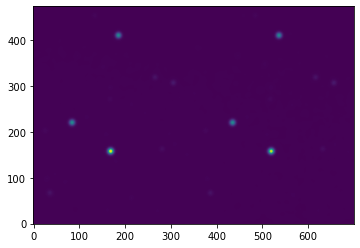

In [9]:
fig, ax = plt.subplots()
ax.imshow(longarr[0].T, origin='lower')
  
plt.show()

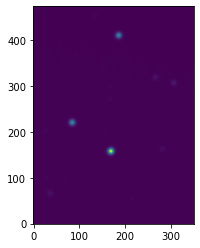

In [11]:
fig, ax = plt.subplots()
ax.imshow(Fdatlist[0].T, origin='lower')
  
plt.show()

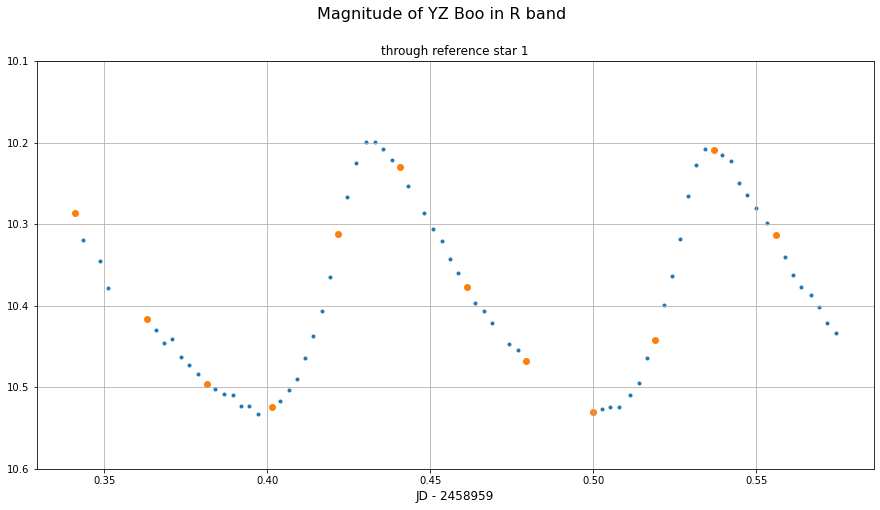

In [22]:
JDinds = [0,4,11,18,26,33,40,46,47,54,61,68]

YZBoo1_R = np.loadtxt("YZ_BOO_R.txt")

target_R_JD = np.loadtxt("YZ_BOO_R_JD.txt") 

plt.figure(figsize=(15,7.5))
plt.scatter(target_R_JD, YZBoo1_R, marker='.')
plt.scatter(target_R_JD[JDinds], YZBoo1_R[JDinds], marker='o')
plt.title("through reference star 1", fontsize=12)
plt.suptitle("Magnitude of YZ Boo in R band", fontsize=16)
plt.xlabel("JD - 2458959", fontsize=12)
plt.ylim([10.6, 10.1])
plt.grid()
plt.show()